# Lab Week 7: Deep Learning and Neural Network Introduction using Tensorflow/Keras

In this lab, you will start working with Deep Neural Networks. 
You will explore how to implement those networks with a few lines of code using the TensorFlow library with Keras and then train them on a dataset.

The main focus of the first part of this lab is for you to read, understand and execute code. If anything is unclear, you should look into the linked web pages and documentation. Alternatively, speak to your lab tutor.
There are quite a few resources linked and you are encouraged to follow them and read up on the documentaiton. 

The latter half of this lab will have you change some of the implementations and observe how the results will vary. 

## Importing of Packages
This lab requires you to update your conda environment by importing the one given in GCU-Learn or installing further Python packages.
Therefore, alternatively either:

- import the lab_environment_dl.yml from the Lab Setup section on GCU-learn to your Anaconda and select it to run the code in your code editor

or use your own environment and install the packages:

 - install TensorFlow 2.10.0: `pip install tensorflow==2.10.0`
 - install tensor datasets:  `pip install tensorflow_datasets==4.7.0`
- install jinja 2 (for displaying the dataset info): `pip install Jinja2`

**Task**: Test whether the imports in the cell below work, if not, install the required packages.

In [116]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tf_datasets
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)
from sklearn.metrics import classification_report

## Dataset

The data that we are going to use in today's lab is the [penguin dataset](https://www.tensorflow.org/datasets/catalog/penguins#penguinsprocessed_default_config). Imagine you are a ML expert and a Zoologist has asked you to help in classifying what kind of penguin species has been observed based on four different features such as body weight, beak dimensions and flipper length. 
Specifically, you will work with data to classify three species of penguins:


<img src=https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png width="500">

(Artwork by @allison_horst)



- Adelie
- Chinstrap 
- Gentoo

Have a look at the original dataset link to find out more about the data [here](https://allisonhorst.github.io/palmerpenguins/).
You will note that this is a supervised multi-class classification problem.

There are 344 entries in this dataset and conveniently, there is a cleaned and prepared version available as well.

The following code cell loads the entirety of the dataset (not cleaned and prepared) and displays its information

In [117]:
dataset, info = tf_datasets.load('penguins/simple', split='train', with_info=True)

# Create a pandas dataframe from the dataset
dataset_df = tf_datasets.as_dataframe(dataset)
print(dataset_df.head(10))

# Print the dataset info
print(info)


   body_mass_g  culmen_depth_mm  culmen_length_mm  flipper_length_mm  island  \
0       4200.0             13.9         45.500000              210.0       0   
1       4650.0             13.7         40.900002              214.0       0   
2       5300.0             14.2         51.299999              218.0       0   
3       5650.0             15.0         47.799999              215.0       0   
4       5050.0             15.8         46.299999              215.0       0   
5       4650.0             19.1         39.799999              184.0       1   
6       3900.0             17.5         41.099998              190.0       1   
7       3800.0             19.0         49.500000              200.0       1   
8       3700.0             18.6         41.400002              191.0       0   
9       3725.0             17.0         40.700001              190.0       1   

   sex  species  
0    0        2  
1    0        2  
2    1        2  
3    1        2  
4    1        2  
5    1     

You will be able to see that there are feature columns and the last column, *species*,  determines the label for each sample (row).

### Data Preparation and Segregation
As mentioned, we luckily also have a cleaned and prepared version of this dataset available. This version removes all NaN entries and retains 4 normalised numerical features, leading to a total number of 334 samples. 

Depending on your dataset, you may have seen different options for how to split your dataset. Pandas and SciKit learn offer different functions and so does the Tensorflow Dataset library that we use. 
For this dataset, we are using an 80%-20%, train-test split. 

We are omitting a validation dataset for the purpose of this exercise due to the small dataset size. The syntax for the TensorFlow Dataset library is different from the train_test_split in scikit-learn. Here, we are simply stating that the available data should be split with 80% for the training part (`'train[:80%]'`) and 20% for the testing part (`'train[80%:]'`). This uses indexing and states that 0-80% should belong to the train set (:80%) and the remainder (80%:) to the test set. 

In [118]:
# split the data into training and testing. 80/20
dataset, info = tf_datasets.load('penguins/processed', split=['train[:80%]', 'train[80%:]'], with_info=True, as_supervised=True)
# extract the train and test sub-sets
train_dataset = dataset[0]
test_dataset = dataset[1]

# convert datasets to numpy arrays
# NOTE: You do not need to understand this part of the code. This is just to convert the dataset to a numpy array to make it simpler down the line. 
X_train = np.array([x.numpy() for x in train_dataset.map(lambda x, y: x)])
y_train = keras.utils.to_categorical(np.array([y.numpy() for y in train_dataset.map(lambda x, y: y)]))

X_test = np.array([x.numpy() for x in test_dataset.map(lambda x, y: x)])
y_test = keras.utils.to_categorical(np.array([y.numpy() for y in test_dataset.map(lambda x, y: y)]))

print(X_train.shape, y_train.shape, "Training Data/Labels Shape")
print(X_test.shape, y_test.shape, "Testing Data/Labels Shape")


(267, 4) (267, 3) Training Data/Labels Shape
(67, 4) (67, 3) Testing Data/Labels Shape


# Neural Network Models

A model for classification purposes is a specific instance of an ML learning algorithm. This model learns the mapping function, turning the input features it receives from a sample, into an output. In our case, we are determining the class of the penguin, based on its features. 

On an abstract level, a deep neural network consists of three main types of layers:
- Input layer: The layer that receives the input
- Hidden layer: Layers that perform the computations
- Output layers: Layer which generates the prediction.

<img src=https://developers.google.com/static/machine-learning/glossary/images/HiddenLayerBigPicture.png width="500">

(Image Source: Google (2022), [https://developers.google.com/machine-learning/glossary/#hidden_layer](https://developers.google.com/machine-learning/glossary/#hidden_layer) )

The neural network that we are going to use is also known as a fully connected neural network. It received its name as every neuron in a previous layer, is connected to all the neurons in the subsequent layer. 
When we define a neural network, we manually set the number of layers and how many neurons each layer shall have. 

Each connection between neurons of different layers contains weight parameters and as a feature is passed from one layer to the next, the weights are multiplied with the input in addition to adding a bias. The layers that contain the neurons are also called fully connected layers, (Dense in Keras). 
We can then manually define a neural network, by stacking the layers together. 

**Task** Read the Keras Guide to Sequential Models until the section "Feature Extraction with a Sequential Model": https://keras.io/guides/sequential_model/ 
This should give you an idea of the syntax on how to create neural network models in Keras and help you understand the code to build the model in the next cell. 

In [119]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 10)                50        
                                                                 
 dense_34 (Dense)            (None, 10)                110       
                                                                 
 dense_35 (Dense)            (None, 3)                 33        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In the previous cell, we created a very simple sequential, fully connected neural network using [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers.

You will have noticed, that we have specified the activation function with `activation='relu'`. Activation functions allow neural networks to model non-linear relationships in the data. 
Instead of using activation functions within the Dense layer, we can also separately add [activation layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) similar to the following bit of code:
```
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4)),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(3),
    tf.keras.layers.Activation('softmax')
])
```
This is very useful when building more complex model architectures. 

The Softmax activation is used at the output layer as it generates a probability distribution between all three outputs. 

# Model Training

Now that we have created our desired model architecture with three hidden layers, the model is ready to be trained. However, we still need to set some hyperparameters and training configurations before we can let the model 'loose' on the dataset. 

## Model Compiling

The Keras method `model.compile()`  readies a model for the training stage. Within this method, you can specify the **loss** and **optimizer** choices. 

Remember, the loss function is used to determine the difference between our predicted, and actual output and guides the model training. Keras has implemented [various loss functions](https://keras.io/api/losses/) for classification and regression tasks however we will use the Cross-Entropy Loss, specifically the [categorical cross entropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class): `loss='categorical_crossentropy'`.

To update our neural network weights during training we also need to specify what optimizer to use. In the lecture, we have seen optimizers such as Stochastic Gradient Descent and Adam. You define the [optimizer choice](https://keras.io/api/optimizers/) by setting the optimizer argument, in our case we want to use Adam:  `optimizer='adam'`.

In the last stage for compiling our model, we want to set a metric to observe the training process. For this, we can use the accuracy as this is a simple classification problem: `metrics=['accuracy']`

Note that instead of using Python strings to define the optimizer and loss you can also use Python Objects similar to the code sample below:
```
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
```
This allows for more customization, as when creating the loss and optimizer objects you can pass on further arguments such as a custom learning rate. 

In [120]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Model Fitting

Fitting the data to neural networks is an iterative process. A sample is passed through the neural network and the predicted output is compared with the ground truth using the loss function. The gradient is then calculated and the weights are updated based on what impact they had in creating the output, in the direction that reduces the training loss.

Model training is executed by calling the  `model.fit()` [function](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) on the data. During this 'fitting' process, the model sees different samples of the training dataset.

The important keywords to remember here are :
- Epoch: An iteration of the model fitting over the whole training dataset
- Batch Size: The number of concurrent samples that the model uses to update its weights. 


Both of those are also hyperparameters that you need to set in your model training stage. 

For the epochs, there is no golden rule as to how long a model should be trained. Just be wary that the number of epochs can influence underfitting (training too little) or overfitting (training too long). For our case, we set the number of epochs to be 200,  `epochs=200`.

A larger batch size uses more memory as more samples need to be retained in the training process. A good rule of thumb is to set the batch size to a power of 2 (2,4,8,16,32 ... ). We set the batch size to be 4: `batch_size=4`

In [121]:
# we are using our numpy arrays with the training data/labels

history = model.fit(x=X_train, y=y_train, epochs=200, batch_size=4)

Epoch 1/200
67/67 [==============================] - 3s 2ms/step - loss: 1.0929 - accuracy: 0.3483
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 1.0189 - accuracy: 0.4682
Epoch 3/200
67/67 [==============================] - 0s 2ms/step - loss: 0.9675 - accuracy: 0.7491
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 0.9020 - accuracy: 0.7678
Epoch 5/200
67/67 [==============================] - 0s 2ms/step - loss: 0.8192 - accuracy: 0.7753
Epoch 6/200
67/67 [==============================] - 0s 2ms/step - loss: 0.6994 - accuracy: 0.7753
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - loss: 0.6005 - accuracy: 0.7753
Epoch 8/200
67/67 [==============================] - 0s 2ms/step - loss: 0.5334 - accuracy: 0.7753
Epoch 9/200
67/67 [==============================] - 0s 2ms/step - loss: 0.4881 - accuracy: 0.7753
Epoch 10/200
67/67 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.7753
Epoch 11/

### Visualize the Training Process

You will see that our model has now trained for a total of 200 epochs. You can also observe that the training loss has decreased and the training accuracy has increased.
Note, that we have saved the model's training history in a variable called `history`. We can utilize this to plot some graphs that show our model's progress.

Alternatively, you could also use a library such as [Tensorboard](https://www.tensorflow.org/tensorboard/get_started).

If you observe the graphs created by the cell below you can see that the model's loss starts to converge after around 175 epochs. This means that the loss has reached an optimum and may not decrease further. 

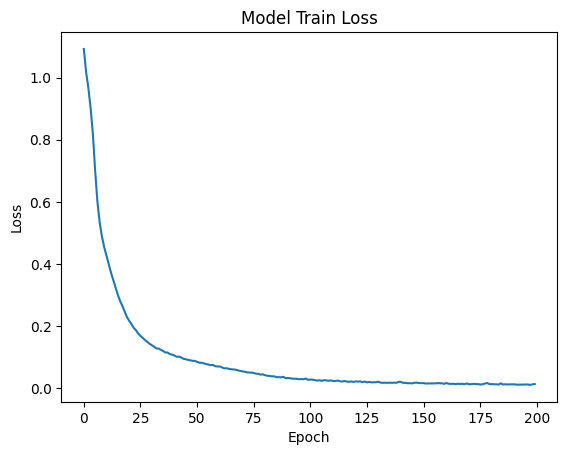

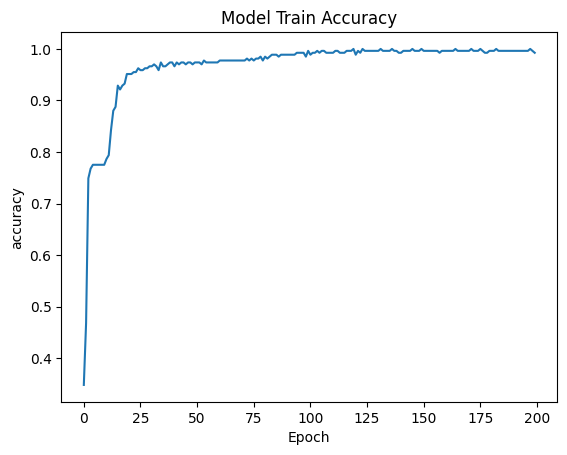

In [122]:
plt.plot(history.history['loss'])
plt.title('Model Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.plot(history.history['accuracy'])
plt.title('Model Train Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.show()

# Model Evaluation

After training, we can evaluate the performance of our model. Keras offers a handy function to give a quick overview of the performance with the `model.evaluate()` function. However, this only returns the metric that we have specified during the `model.compile()` stage!
Here, we then pass the test data and their labels to the model.

In [123]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

3/3 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 1.0000
Test Loss:  0.006400766782462597
Test Accuracy:  1.0


As you can see, our model has not performed too badly, judging simply by the accuracy metric. 
It would be better to see a detailed classification output. For this, we can pass samples to the model via the `model.predict()` function. This simply returns the confidence scores of the model. 

We then print the predictions and use them in scikit-learn's classification report. 

In [124]:
predictions = model.predict(X_test)
print(predictions[:10])

# .argmax() returns the index of the highest value in the array, meaning the class that the model predicted
# class_names defined in the type of pengiun
class_names = ['Adélie', 'Chinstrap', 'Gentoo']
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=class_names))


3/3 [==============================] - 0s 2ms/step
[[0.999992   0.00000803 0.        ]
 [0.         0.00001678 0.9999832 ]
 [0.999907   0.00009301 0.00000001]
 [0.99989796 0.00010193 0.00000017]
 [0.00000001 0.         1.        ]
 [0.00000736 0.0000008  0.9999919 ]
 [0.00000326 0.         0.9999968 ]
 [0.         0.00000806 0.9999919 ]
 [0.         0.00080435 0.99919564]
 [0.9999572  0.00004276 0.        ]]
              precision    recall  f1-score   support

      Adélie       1.00      1.00      1.00        31
   Chinstrap       1.00      1.00      1.00         8
      Gentoo       1.00      1.00      1.00        28

    accuracy                           1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67



# General Information
As you will have seen by executing the previous cells in this notebook, the use of deep learning models follows the sample principles that you have seen in other models such as loading, preparing and segregating the data, followed by training and evaluation of a model. 

Deep learning models are very capable and achieve state-of-the-art in many machine learning tasks, therefore it is very useful to understand how you can make use of them.
Although there are different Deep Learning libraries available ( [Pytorch for example](https://pytorch.org/) ) the concepts are very much the same. 

With more practice applying neural networks you will gain an intuition of optimal hyperparameters and implementation routines and will improve your results, although at the beginning it will mostly be trial and error.

# Further Tasks
- Change the hyperparameters such as epochs or batch size or add further layers into the neural network architecture. Does this change the results?
- Use a different optimizer such as Stochastic Gradient Descent (SGD) and change its learning rate. Does this change the results?
- Add a [dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer into the hidden layers in this architecture.  Use this layer to drop a rate of 50% of connections. Does this change the results?
- Until now we have only used the ReLU activation functions. Change those functions to another activation such as "sigmoid" or "tanh". Does this change the results?
- Revisit the Iris Notebook from Week 1. You should now understand the code much better. Try the above changes such as changing the model architecture or hyperparameters to obtain a better result.

---

Now that you have seen the basics of implementing deep neural networks you can work on some **more advanced tasks below**, which should give a better overview of the capabilities that are offered in libraries. You should read and work through the following tutorials on the Tensorflow Documentation and work on the task given:

[Saving and Restoring Keras Models](https://www.tensorflow.org/guide/keras/save_and_serialize#saving_the_architecture)  (until: How SavedModel handles custom objects)
- **TASK**:  Save the penguin neural network model to a file. Write code to restore it in the next cell. Restart the whole notebook and run all cells but the ones where you fit the model and save it. You should simply restore the model and its training data. 

The [Keras Functional API](https://www.tensorflow.org/guide/keras/functional#setup) (until: Manipulate complex graph topologies)
- **TASK**:  Turn the model in this notebook from a sequential Keras model into a functional model. 


---
